In [ ]:
import seaborn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/10718_Fall21/good_feature

/content/drive/MyDrive/10718_Fall21/good_feature


In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
%matplotlib inline
color = sns.color_palette()
from pandas.plotting import table
import scipy
from scipy.stats import pearsonr, spearmanr
from wordcloud import WordCloud, STOPWORDS
import datetime as dt
import plotly
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
# Load data


**cohort correction**

In [ ]:
master = pd.read_csv('processed_mastersheet1025.zip')
master = master.drop(master[master.percent_fulfilled >= 1.0].index)
master.head(10)

,Unnamed: 0,projectid,teacher_acctid,schoolid,school_state,school_metro,school_charter,teacher_prefix,teacher_teach_for_america,primary_focus_subject,resource_type,poverty_level,grade_level,total_price_excluding_optional_support,students_reached,date_posted,title_num_words,description_num_words,statement_num_words,essay_num_words,num_donors,num_teachers,total_donation_amount,avg_msg_num_words,fully_funded,day_of_week_posted,percent_fulfilled,amount_remaining,school_pct_funded,teacher_pct_funded
0,0,62526d85d2a1818432d03d600969e99c,ebc7c90b6c92a069432e0714b8d93dfd,5aca9711ff0e4b37db48701f46f73036,IL,suburban,f,Mrs.,f,Special Needs,Other,moderate poverty,Grades 3-5,444.36,7.0,2013-12-31,8.0,33.0,10.0,220.0,1.0,0.0,42.50,30.0,t,1,0.095643,401.86,0.500000,0.0
1,1,33d59ac771b80222ad63ef0f4ac47ade,de83b4c1f6428a15032c207c1d5e572a,d91a805b213bf74ae77b94e0de2b73ad,ID,urban,f,Mrs.,f,Mathematics,Supplies,high poverty,Grades 3-5,233.24,30.0,2013-12-31,3.0,33.0,14.0,175.0,0.0,0.0,0.00,0.0,f,1,0.000000,233.24,0.500000,0.5
2,2,1a3aaeffc56dd2a421e37d8298024c0a,f4c9ed095b85458dcf858e25f203af00,9310d3eb447a4e46bc5fc31ed007ceac,NH,suburban,f,Mrs.,f,Environmental Science,Technology,moderate poverty,Grades 6-8,285.09,230.0,2013-12-31,3.0,35.0,29.0,390.0,0.0,0.0,0.00,0.0,f,1,0.000000,285.09,0.500000,0.5
3,3,33aa19ee4da4c5adf47d0dfb84fab5ef,17768031eb40de8d4497dbb54df48742,9ac70da58322783f82152eecc140a812,VA,urban,f,Ms.,f,Literacy,Other,highest poverty,Grades PreK-2,232.94,18.0,2013-12-31,3.0,34.0,18.0,187.0,1.0,0.0,42.50,0.0,f,1,0.182450,190.44,0.541667,0.6
4,4,e31c0ea8b68f404699dfb0d39e9bc99b,0f1bc5b4700fd33383be104442660178,cb9f688cf59e3ee22a087d616ca8f5d7,IL,urban,f,Mr.,f,Environmental Science,Supplies,highest poverty,Grades 6-8,513.41,70.0,2013-12-31,3.0,35.0,30.0,347.0,0.0,0.0,0.00,0.0,t,1,0.000000,513.41,0.000000,0.0
5,5,c685c844476d7ed75bf87699eeafd682,4b19500fb087a635c98061505f1e6c6f,34c650f9f6d5c3e42b8e2169c280ecb7,SC,urban,f,Mrs.,f,Literature & Writing,Supplies,high poverty,Grades PreK-2,688.11,22.0,2013-12-31,6.0,32.0,15.0,187.0,2.0,0.0,42.50,24.5,f,1,0.061763,645.61,0.000000,0.0
6,6,a4b234feb2b72921ed59850d5c873d62,620982375045fa11d872702f26ab98bb,da1985df161ba5c3842fc99579b6e4b1,KY,urban,f,Mrs.,f,Literature & Writing,Technology,highest poverty,Grades PreK-2,935.16,25.0,2013-12-31,2.0,32.0,28.0,396.0,0.0,0.0,0.00,0.0,f,1,0.000000,935.16,0.625000,0.0
7,7,0ff5dec32bf793243a8b0b2c023a81f0,ec5b110df87bd511b508961676d08b6c,72e2b0cb2eecfdc37e67e0eaf10da07b,FL,rural,f,Ms.,f,Literacy,Technology,highest poverty,Grades PreK-2,809.32,17.0,2013-12-31,2.0,34.0,19.0,443.0,2.0,1.0,709.75,9.5,t,1,0.876971,99.57,0.000000,0.0
11,11,c83d0794e67ec95f680cbb058c4523ff,535ab721f66316cf26a1d5ce1d9184f5,9f37b7e58dae8805882cbae215bb5e2a,FL,suburban,f,Mrs.,f,Applied Sciences,Books,high poverty,Grades 3-5,269.90,36.0,2013-12-31,3.0,36.0,28.0,192.0,0.0,0.0,0.00,0.0,f,1,0.000000,269.90,0.000000,0.0
12,12,3b6bddd1df0e310066d81c2b89771b5c,60a251a9fe882561405e9f6e135afb75,cf7b5a7b866094184208f0f4bc282e6a,NM,urban,f,Mrs.,f,Civics & Government,Technology,highest poverty,Grades 9-12,519.03,160.0,2013-12-31,5.0,38.0,11.0,194.0,0.0,0.0,0.00,0.0,t,1,0.000000,519.03,0.000000,0.0


In [ ]:
t_mask = (master['date_posted'] >= '2013-02-01') & (master['date_posted'] <= '2013-07-31')
v_mask = (master['date_posted'] >= '2013-12-01') & (master['date_posted'] <= '2013-12-31')
train, validation = master.loc[t_mask], master.loc[v_mask]

In [ ]:
def run_baseline1(df, k):
  if k == 0.0:
      precision, recall = 1, 0
  else:
      df.sort_values(by=['total_price_excluding_optional_support'], ascending = False, inplace = True)
      br = df['fully_funded'].value_counts().f / df.shape[0]
      if k == 1.0:
        precision, recall = br, 1
      else:
        sub = df.head(int(df.shape[0] * k)) # predict these as 1: not fully_funded, or 'f'
        rem = df.tail(df.shape[0] - int(df.shape[0] * k))
        tp = sub['fully_funded'].value_counts().f
        fp = sub.shape[0] - tp
        fn = rem['fully_funded'].value_counts().f
        
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
  if k == 0.1:
    print('@k={:.2f}, precision={:.3f}, recall={:.3f}'.format(k, precision, recall))
  return precision, recall

In [ ]:
grid = np.arange(0,1.1,0.1)
pre_log, rec_log = np.zeros_like(grid), np.zeros_like(grid)
for i, k in enumerate(grid):
  tmp = run_baseline1(validation, k)
  pre_log[i], rec_log[i] = tmp[0], tmp[1]

@k=0.10, precision=0.720, recall=0.174


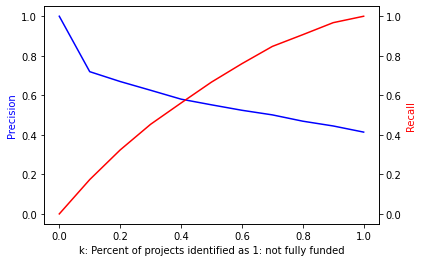

In [ ]:
# f, axs = plt.subplots(1,2,figsize=(15,5))
# axs1 = axs[0]
f, axs1 = plt.subplots()
axs2 = axs1.twinx()
axs1.plot(grid, pre_log, 'b', label = 'Precision')
axs2.plot(grid, rec_log, 'r', label = 'Recall')
axs1.set_ylabel('Precision', color = 'b')
axs1.set_ylim(-0.05,1.05)
axs2.set_ylabel('Recall', color = 'r')
axs2.set_ylim(-0.05,1.05)
axs1.set_xlabel('k: Percent of projects identified as 1: not fully funded')
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer


from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.svm import SVC

from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score


from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm

from sklearn import model_selection

from sklearn.metrics import precision_recall_curve, auc, roc_curve

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).



**Preprocessing**

In [ ]:
master = pd.read_csv('processed_mastersheet1025.zip')
master = master.drop(master[master.percent_fulfilled >= 1.0].index)
master.head(10)

,Unnamed: 0,projectid,teacher_acctid,schoolid,school_state,school_metro,school_charter,teacher_prefix,teacher_teach_for_america,primary_focus_subject,resource_type,poverty_level,grade_level,total_price_excluding_optional_support,students_reached,date_posted,title_num_words,description_num_words,statement_num_words,essay_num_words,num_donors,num_teachers,total_donation_amount,avg_msg_num_words,fully_funded,day_of_week_posted,percent_fulfilled,amount_remaining,school_pct_funded,teacher_pct_funded
0,0,62526d85d2a1818432d03d600969e99c,ebc7c90b6c92a069432e0714b8d93dfd,5aca9711ff0e4b37db48701f46f73036,IL,suburban,f,Mrs.,f,Special Needs,Other,moderate poverty,Grades 3-5,444.36,7.0,2013-12-31,8.0,33.0,10.0,220.0,1.0,0.0,42.50,30.0,t,1,0.095643,401.86,0.500000,0.0
1,1,33d59ac771b80222ad63ef0f4ac47ade,de83b4c1f6428a15032c207c1d5e572a,d91a805b213bf74ae77b94e0de2b73ad,ID,urban,f,Mrs.,f,Mathematics,Supplies,high poverty,Grades 3-5,233.24,30.0,2013-12-31,3.0,33.0,14.0,175.0,0.0,0.0,0.00,0.0,f,1,0.000000,233.24,0.500000,0.5
2,2,1a3aaeffc56dd2a421e37d8298024c0a,f4c9ed095b85458dcf858e25f203af00,9310d3eb447a4e46bc5fc31ed007ceac,NH,suburban,f,Mrs.,f,Environmental Science,Technology,moderate poverty,Grades 6-8,285.09,230.0,2013-12-31,3.0,35.0,29.0,390.0,0.0,0.0,0.00,0.0,f,1,0.000000,285.09,0.500000,0.5
3,3,33aa19ee4da4c5adf47d0dfb84fab5ef,17768031eb40de8d4497dbb54df48742,9ac70da58322783f82152eecc140a812,VA,urban,f,Ms.,f,Literacy,Other,highest poverty,Grades PreK-2,232.94,18.0,2013-12-31,3.0,34.0,18.0,187.0,1.0,0.0,42.50,0.0,f,1,0.182450,190.44,0.541667,0.6
4,4,e31c0ea8b68f404699dfb0d39e9bc99b,0f1bc5b4700fd33383be104442660178,cb9f688cf59e3ee22a087d616ca8f5d7,IL,urban,f,Mr.,f,Environmental Science,Supplies,highest poverty,Grades 6-8,513.41,70.0,2013-12-31,3.0,35.0,30.0,347.0,0.0,0.0,0.00,0.0,t,1,0.000000,513.41,0.000000,0.0
5,5,c685c844476d7ed75bf87699eeafd682,4b19500fb087a635c98061505f1e6c6f,34c650f9f6d5c3e42b8e2169c280ecb7,SC,urban,f,Mrs.,f,Literature & Writing,Supplies,high poverty,Grades PreK-2,688.11,22.0,2013-12-31,6.0,32.0,15.0,187.0,2.0,0.0,42.50,24.5,f,1,0.061763,645.61,0.000000,0.0
6,6,a4b234feb2b72921ed59850d5c873d62,620982375045fa11d872702f26ab98bb,da1985df161ba5c3842fc99579b6e4b1,KY,urban,f,Mrs.,f,Literature & Writing,Technology,highest poverty,Grades PreK-2,935.16,25.0,2013-12-31,2.0,32.0,28.0,396.0,0.0,0.0,0.00,0.0,f,1,0.000000,935.16,0.625000,0.0
7,7,0ff5dec32bf793243a8b0b2c023a81f0,ec5b110df87bd511b508961676d08b6c,72e2b0cb2eecfdc37e67e0eaf10da07b,FL,rural,f,Ms.,f,Literacy,Technology,highest poverty,Grades PreK-2,809.32,17.0,2013-12-31,2.0,34.0,19.0,443.0,2.0,1.0,709.75,9.5,t,1,0.876971,99.57,0.000000,0.0
11,11,c83d0794e67ec95f680cbb058c4523ff,535ab721f66316cf26a1d5ce1d9184f5,9f37b7e58dae8805882cbae215bb5e2a,FL,suburban,f,Mrs.,f,Applied Sciences,Books,high poverty,Grades 3-5,269.90,36.0,2013-12-31,3.0,36.0,28.0,192.0,0.0,0.0,0.00,0.0,f,1,0.000000,269.90,0.000000,0.0
12,12,3b6bddd1df0e310066d81c2b89771b5c,60a251a9fe882561405e9f6e135afb75,cf7b5a7b866094184208f0f4bc282e6a,NM,urban,f,Mrs.,f,Civics & Government,Technology,highest poverty,Grades 9-12,519.03,160.0,2013-12-31,5.0,38.0,11.0,194.0,0.0,0.0,0.00,0.0,t,1,0.000000,519.03,0.000000,0.0


In [ ]:
master['date_posted'] = pd.to_datetime(master['date_posted'])
master.fully_funded = master.fully_funded.replace({'f':1, 't':0})
master.head(2)

,Unnamed: 0,projectid,teacher_acctid,schoolid,school_state,school_metro,school_charter,teacher_prefix,teacher_teach_for_america,primary_focus_subject,resource_type,poverty_level,grade_level,total_price_excluding_optional_support,students_reached,date_posted,title_num_words,description_num_words,statement_num_words,essay_num_words,num_donors,num_teachers,total_donation_amount,avg_msg_num_words,fully_funded,day_of_week_posted,percent_fulfilled,amount_remaining,school_pct_funded,teacher_pct_funded
0,0,62526d85d2a1818432d03d600969e99c,ebc7c90b6c92a069432e0714b8d93dfd,5aca9711ff0e4b37db48701f46f73036,IL,suburban,f,Mrs.,f,Special Needs,Other,moderate poverty,Grades 3-5,444.36,7.0,2013-12-31,8.0,33.0,10.0,220.0,1.0,0.0,42.5,30.0,0,1,0.095643,401.86,0.5,0.0
1,1,33d59ac771b80222ad63ef0f4ac47ade,de83b4c1f6428a15032c207c1d5e572a,d91a805b213bf74ae77b94e0de2b73ad,ID,urban,f,Mrs.,f,Mathematics,Supplies,high poverty,Grades 3-5,233.24,30.0,2013-12-31,3.0,33.0,14.0,175.0,0.0,0.0,0.0,0.0,1,1,0.000000,233.24,0.5,0.5


 Convert Categorical data

In [ ]:
import collections
def getMap(name):
    tmp = dict(master[name].value_counts())
    freq = list(reversed(sorted([tmp[i] for i in tmp])))
    res = collections.defaultdict(int)
    for key, val in tmp.items():
      res[key] = freq.index(val)
    return res


In [ ]:
code_school_state = master["school_state"].map(getMap('school_state'))
code_school_state = code_school_state.fillna(code_school_state.mean())


In [ ]:
code_school_metro = master['school_metro'].map(getMap('school_metro'))
code_school_metro = code_school_metro.fillna(code_school_metro.mean())

In [ ]:
code_school_charter = master['school_charter'].map(getMap('school_charter'))

In [ ]:
code_teacher_prefix = master['teacher_prefix'].map(getMap('teacher_prefix'))

In [ ]:
code_teacher_teach_for_america = master['teacher_teach_for_america'].map(getMap('teacher_teach_for_america'))

In [ ]:
code_primary_focus_subject = master['primary_focus_subject'].map(getMap('primary_focus_subject'))

In [ ]:
code_resource_type = master['resource_type'].map(getMap('resource_type'))

In [ ]:
code_poverty_level = master['poverty_level'].map(getMap('poverty_level'))

In [ ]:
code_grade_level = master['grade_level'].map(getMap('grade_level'))

In [ ]:
code_day_of_week_posted = master['day_of_week_posted'].map(getMap('day_of_week_posted'))

In [ ]:
norm_code_school_state = (code_school_state - code_school_state.mean()) / code_school_state.std()
norm_code_school_metro = (code_school_metro - code_school_metro.mean()) / code_school_metro.std()
norm_code_school_charter = (code_school_charter - code_school_charter.mean()) / code_school_charter.std()
norm_code_teacher_prefix = (code_teacher_prefix - code_teacher_prefix.mean()) / code_teacher_prefix.std()
norm_code_teacher_teach_for_america = (code_teacher_teach_for_america - code_teacher_teach_for_america.mean()) / code_teacher_teach_for_america.std()
norm_code_primary_focus_subject = (code_primary_focus_subject - code_primary_focus_subject.mean()) / code_primary_focus_subject.std()
norm_code_resource_type = (code_resource_type - code_resource_type.mean()) / code_resource_type.std()
norm_code_poverty_level = (code_poverty_level - code_poverty_level.mean()) / code_poverty_level.std()
norm_code_grade_level = (code_grade_level - code_grade_level.mean()) / code_grade_level.std()
norm_code_day_of_week_posted = (code_day_of_week_posted - code_day_of_week_posted.mean()) / code_day_of_week_posted.std()

In [ ]:
norm_code_teacher_prefix.isna().sum()

0

In [ ]:
num_features = master[['total_price_excluding_optional_support','students_reached','title_num_words','description_num_words','statement_num_words','essay_num_words','num_donors','num_teachers','avg_msg_num_words','percent_fulfilled','amount_remaining','school_pct_funded','teacher_pct_funded']]
labels = master['fully_funded']

In [ ]:
num_features.head()

,total_price_excluding_optional_support,students_reached,title_num_words,description_num_words,statement_num_words,essay_num_words,num_donors,num_teachers,avg_msg_num_words,percent_fulfilled,amount_remaining,school_pct_funded,teacher_pct_funded
0,444.36,7.0,8.0,33.0,10.0,220.0,1.0,0.0,30.0,0.095643,401.86,0.500000,0.0
1,233.24,30.0,3.0,33.0,14.0,175.0,0.0,0.0,0.0,0.000000,233.24,0.500000,0.5
2,285.09,230.0,3.0,35.0,29.0,390.0,0.0,0.0,0.0,0.000000,285.09,0.500000,0.5
3,232.94,18.0,3.0,34.0,18.0,187.0,1.0,0.0,0.0,0.182450,190.44,0.541667,0.6
4,513.41,70.0,3.0,35.0,30.0,347.0,0.0,0.0,0.0,0.000000,513.41,0.000000,0.0


In [ ]:
num_features['total_price_excluding_optional_support'] = num_features['total_price_excluding_optional_support'].clip(upper = 2000)
num_features['students_reached'] = num_features['students_reached'].clip(upper = 200)
num_features['statement_num_words'] = num_features['statement_num_words'].clip(upper = 250)
num_features['num_donors'] = num_features['num_donors'].clip(upper = 10)
num_features['num_teachers'] = num_features['num_teachers'].clip(upper = 5)
num_features['avg_msg_num_words'] = num_features['avg_msg_num_words'].clip(upper = 100)
num_features['amount_remaining'] = num_features['amount_remaining'].clip(upper = 2000)

In [ ]:
norm_num_features = (num_features - num_features.mean())/num_features.std()

In [ ]:
norm_num_features.isna().sum()

total_price_excluding_optional_support       0
students_reached                           116
title_num_words                             15
description_num_words                       89
statement_num_words                       1292
essay_num_words                              3
num_donors                                   0
num_teachers                                 0
avg_msg_num_words                            0
percent_fulfilled                          299
amount_remaining                             0
school_pct_funded                            0
teacher_pct_funded                           0
dtype: int64

In [ ]:
norm_num_features['students_reached'] = norm_num_features['students_reached'].fillna(norm_num_features['students_reached'].mean())
norm_num_features['title_num_words'] = norm_num_features['title_num_words'].fillna(norm_num_features['title_num_words'].mean())
norm_num_features['description_num_words'] = norm_num_features['description_num_words'].fillna(norm_num_features['description_num_words'].mean())
norm_num_features['statement_num_words'] = norm_num_features['statement_num_words'].fillna(norm_num_features['statement_num_words'].mean())
norm_num_features['percent_fulfilled'] = norm_num_features['percent_fulfilled'].fillna(norm_num_features['percent_fulfilled'].mean())
norm_num_features['essay_num_words'] = norm_num_features['essay_num_words'].fillna(norm_num_features['essay_num_words'].mean())


In [ ]:
norm_num_features.isna().sum()

total_price_excluding_optional_support    0
students_reached                          0
title_num_words                           0
description_num_words                     0
statement_num_words                       0
essay_num_words                           0
num_donors                                0
num_teachers                              0
avg_msg_num_words                         0
percent_fulfilled                         0
amount_remaining                          0
school_pct_funded                         0
teacher_pct_funded                        0
dtype: int64

In [ ]:
from scipy.sparse import hstack
features = pd.concat([norm_num_features, norm_code_school_state, norm_code_school_metro, norm_code_school_charter, norm_code_teacher_prefix, norm_code_teacher_teach_for_america, norm_code_primary_focus_subject, norm_code_resource_type, norm_code_poverty_level,norm_code_grade_level, norm_code_day_of_week_posted], axis = 1)
features.shape

(526994, 23)

In [ ]:
features.head(2)

,total_price_excluding_optional_support,students_reached,title_num_words,description_num_words,statement_num_words,essay_num_words,num_donors,num_teachers,avg_msg_num_words,percent_fulfilled,amount_remaining,school_pct_funded,teacher_pct_funded,school_state,school_metro,school_charter,teacher_prefix,teacher_teach_for_america,primary_focus_subject,resource_type,poverty_level,grade_level,day_of_week_posted
0,-0.139166,-0.942839,1.203844,-0.477753,-1.085948,-0.657773,0.198050,-0.260987,3.202386,0.230526,-0.185409,0.011488,-0.684094,-0.601811,0.740863,-0.300254,-0.920449,-0.235718,-0.245134,1.841029,1.729966,-0.091199,-0.847185
1,-0.767361,-0.568445,-0.960139,-0.477753,-0.636043,-1.159820,-0.402367,-0.260987,-0.425502,-0.376891,-0.687573,0.011488,0.503713,2.848099,-0.673975,-0.300254,-0.920449,-0.235718,-0.429571,-1.072358,0.490380,-0.091199,-0.847185


In [ ]:
t_mask = (master['date_posted'] >= '2013-02-01') & (master['date_posted'] <= '2013-07-31')
v_mask = (master['date_posted'] >= '2013-12-01') & (master['date_posted'] <= '2013-12-31')

In [ ]:
X_train, y_train = features.loc[t_mask], labels.loc[t_mask]
X_test, y_test = features.loc[v_mask], labels.loc[v_mask]

In [ ]:
X_train, y_train, X_test, y_test = X_train.values, y_train.values, X_test.values, y_test.values
print(X_train.shape, X_test.shape)

(34388, 23) (6998, 23)


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/10718_Fall21/')
# drive/MyDrive/10718_Fall21/

In [ ]:
!pip install lime

     |████████████████████████████████| 275 kB 10.1 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=672aabb2f3cfe7577f87e4b46cedd5b9e351e397b5a4104a80d2be2cb0660517
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
# Notes:
# -  Assumes any required data normalization has already been done
# -  Can pass Y (desired response) instead of MR (model fit to Y) to make fitting MAPLE to datasets easy

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import numpy as np

class MAPLE:
 
    def __init__(self, X_train, MR_train, X_val, MR_val, fe_type = "rf", n_estimators = 200, max_features = 0.5, min_samples_leaf = 10, regularization = 0.001):
        
        # Features and the target model response
        self.X_train = X_train
        self.MR_train = MR_train
        self.X_val = X_val
        self.MR_val = MR_val
        
        # Forest Ensemble Parameters
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.min_samples_leaf = min_samples_leaf
        
        # Local Linear Model Parameters
        self.regularization = regularization
        
        # Data parameters
        num_features = X_train.shape[1]
        self.num_features = num_features
        num_train = X_train.shape[0]
        self.num_train = num_train
        num_val = X_val.shape[0]
        
        # Fit a Forest Ensemble to the model response
        if fe_type == "rf":
            fe = RandomForestRegressor(n_estimators = n_estimators, min_samples_leaf = min_samples_leaf, max_features = max_features)
        elif fe_type == "gbrt":
            fe = GradientBoostingRegressor(n_estimators = n_estimators, min_samples_leaf = min_samples_leaf, max_features = max_features, max_depth = None)
        else:
            print("Unknown FE type ", fe)
            import sys
            sys.exit(0)
        fe.fit(X_train, MR_train)
        self.fe = fe
        
        train_leaf_ids = fe.apply(X_train)
        self.train_leaf_ids = train_leaf_ids
        
        val_leaf_ids_list = fe.apply(X_val)
        
        # Compute the feature importances: Non-normalized @ Root
        scores = np.zeros(num_features)
        if fe_type == "rf":
            for i in range(n_estimators):
                splits = fe[i].tree_.feature #-2 indicates leaf, index 0 is root
                if splits[0] != -2:
                    scores[splits[0]] += fe[i].tree_.impurity[0] #impurity reduction not normalized per tree
        elif fe_type == "gbrt":
            for i in range(n_estimators):
                splits = fe[i, 0].tree_.feature #-2 indicates leaf, index 0 is root
                if splits[0] != -2:
                    scores[splits[0]] += fe[i, 0].tree_.impurity[0] #impurity reduction not normalized per tree
        self.feature_scores = scores
        self.mostImpFeats = np.argsort(-scores)
                
        print('Finding the number of features to use for MAPLE')
        retain_best = 0
        rmse_best = np.inf
        # print('Actually, we are skipping this step, best retain = 5')
        for retain in range(1, num_features + 1):
            print('running retain = {}'.format(retain))
            # Drop less important features for local regression
            X_train_p = np.delete(X_train, self.mostImpFeats[retain:], axis = 1)
            X_val_p = np.delete(X_val, self.mostImpFeats[retain:], axis = 1)
                        
            lr_predictions = np.empty([num_val], dtype=float)
            
            for i in range(num_val):
                
                weights = self.training_point_weights(val_leaf_ids_list[i])
                    
                # Local linear model
                lr_model = Ridge(alpha=regularization)
                lr_model.fit(X_train_p, MR_train, weights)
                lr_predictions[i] = lr_model.predict(X_val_p[i].reshape(1, -1))
            
            rmse_curr = np.sqrt(mean_squared_error(lr_predictions, MR_val))
            
            if rmse_curr < rmse_best:
                rmse_best = rmse_curr
                retain_best = retain
                
        self.retain = retain_best
        self.X = np.delete(X_train, self.mostImpFeats[retain_best:], axis = 1)
        print('best retain = {}'.format(self.retain))
                
    def training_point_weights(self, instance_leaf_ids):
        weights = np.zeros(self.num_train)
        for i in range(self.n_estimators):
            # Get the PNNs for each tree (ones with the same leaf_id)
            PNNs_Leaf_Node = np.where(self.train_leaf_ids[:, i] == instance_leaf_ids[i])
            weights[PNNs_Leaf_Node] += 1.0 / len(PNNs_Leaf_Node[0])
        return weights
        
    def explain(self, x):
        
        x = x.reshape(1, -1)
        
        mostImpFeats = np.argsort(-self.feature_scores)
        x_p = np.delete(x, mostImpFeats[self.retain:], axis = 1)
        
        curr_leaf_ids = self.fe.apply(x)[0]
        weights = self.training_point_weights(curr_leaf_ids)
           
        # Local linear model
        lr_model = Ridge(alpha = self.regularization)
        lr_model.fit(self.X, self.MR_train, weights)

        # Get the model coeficients
        coefs = np.zeros(self.num_features + 1)
        coefs[0] = lr_model.intercept_
        coefs[np.sort(mostImpFeats[0:self.retain]) + 1] = lr_model.coef_
        
        # Get the prediction at this point
        prediction = lr_model.predict(x_p.reshape(1, -1))
        
        out = {}
        out["weights"] = weights
        out["coefs"] = coefs
        out["pred"] = prediction
        
        return out

    def predict(self, X):
        n = X.shape[0]
        pred = np.zeros(n)
        for i in range(n):
            exp = self.explain(X[i, :])
            pred[i] = exp["pred"][0]
        return pred

    # Make the predictions based on the forest ensemble (either random forest or gradient boosted regression tree) instead of MAPLE
    def predict_fe(self, X):
        return self.fe.predict(X)

    # Make the predictions based on SILO (no feature selection) instead of MAPLE
    def predict_silo(self, X):
        n = X.shape[0]
        pred = np.zeros(n)
        for i in range(n): #The contents of this inner loop are similar to explain(): doesn't use the features selected by MAPLE or return as much information
            x = X[i, :].reshape(1, -1)
        
            curr_leaf_ids = self.fe.apply(x)[0]
            weights = self.training_point_weights(curr_leaf_ids)
                    
            # Local linear model
            lr_model = Ridge(alpha = self.regularization)
            lr_model.fit(self.X_train, self.MR_train, weights)
                
            pred[i] = lr_model.predict(x)[0]
        
        return pred


**Cell below will exit with error due to bug, AFTER finding best retain and saving the MAPLE models --> still usable**

In [ ]:

# Limit numpy's number of threads
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"

# Base imports
import itertools
import json
import math
from multiprocessing import Pool
import numpy as np
import pandas as pd
import scipy
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier

# Code imports
import sys

from Misc import load_normalize_data, unpack_coefs

from lime import lime_tabular
import pickle

###
# Run Experiments
###

def fit_rf(X_train, y_train, X_test, y_test, n_estimators = 100, max_features = 0.5, min_samples_leaf = 5):
    rf = RandomForestRegressor(n_estimators = n_estimators, min_samples_leaf = min_samples_leaf, max_features = max_features)
    rf.fit(X_train, y_train)
    return rf

def fit_nn(X_train, y_train, X_test, y_test):
    nn = MLPRegressor(max_iter = 500)
    nn.fit(X_train, y_train)
    return nn

def fit_svr(X_train, y_train, X_test, y_test):
    nn = SVR()
    nn.fit(X_train, y_train)
    return nn

datasets = ["donors_choose"]
trials = []
for i in range(3):
    trials.append(i + 1)
args = itertools.product(trials, datasets)

def run(args):
    print('@ trial {}, dataset: {}'.format(args[0], args[1]))
    # Hyperparamaters
    num_perturbations = 5
    
    # Fixes an issue where threads of inherit the same rng state
    scipy.random.seed()
    
    # Arguments
    dataset = args[1]
    trial = args[0]
    
    # Outpt
    out = {}
    


    # Load data
    
    n = X_test.shape[0]
    d = X_test.shape[1]
    
    scales = [0.1, 0.25]
    scales_len = len(scales)
        
    # Fit model
    model = RandomForestClassifier(n_estimators = 500, min_samples_split = 25, random_state=0)
    print('now fitting random forest')
    print(np.count_nonzero(np.isnan(X_train)))
    model.fit(X_train, y_train)
        
    print('Fitting LIME and MAPLE explainers to the model')
    exp_lime = lime_tabular.LimeTabularExplainer(X_train, discretize_continuous=False, mode="regression")
    print('Now fitting Maple')
    exp_maple = MAPLE(X_train, model.predict_proba(X_train)[:,1], X_test, model.predict_proba(X_test)[:,1])
    print('Saving Maple for ')
    print('sort_freq_', dataset + "_" + str(trial))
    with open(dataset + "_" + str(trial) + ".txt", 'wb') as file:
      pickle.dump(exp_maple, file)
    # print('Evaluating model faithfullness on the test set')
    # lime_rmse = np.zeros((scales_len))
    # maple_rmse = np.zeros((scales_len))
    # print('num test:', n)
    # for i in range(n):
    #     if i % 500 == 0:
    #         print('@ i = ', i)
    #     x = X_test[i, :]
    #     # bug in line 100, replace model.predict_proba with a new func that only output model.predict_proba[:,1]
    #     coefs_lime = unpack_coefs(exp_lime, x, model.predict_proba, d, X_train) #Allow full number of features
    
    #     e_maple = exp_maple.explain(x)
    #     coefs_maple = e_maple["coefs"]
        
    #     for j in range(num_perturbations):
            
    #         noise = np.random.normal(loc = 0.0, scale = 1.0, size = d)
            
    #         for k in range(scales_len):
    #             scale = scales[k]
            
    #             x_pert = x + scale * noise
            
    #             model_pred = model.predict_proba(x_pert.reshape(1,-1))
    #             lime_pred = np.dot(np.insert(x_pert, 0, 1), coefs_lime)
    #             maple_pred = np.dot(np.insert(x_pert, 0, 1), coefs_maple)
            
    #             lime_rmse[k] += (lime_pred - model_pred)**2
    #             maple_rmse[k] += (maple_pred - model_pred)**2

    # lime_rmse /= n * num_perturbations
    # maple_rmse /= n * num_perturbations

    # lime_rmse = np.sqrt(lime_rmse)
    # maple_rmse = np.sqrt(maple_rmse)

    # out["lime_rmse_0.1"] = lime_rmse[0]
    # out["maple_rmse_0.1"] = maple_rmse[0]
    # out["lime_rmse_0.25"] = lime_rmse[1]
    # out["maple_rmse_0.25"] = maple_rmse[1]
    # print(dataset + "_" + str(trial))
    # print(out)
    # try:
    #   file = open(dataset + "_" + str(trial) + ".json", "w")
    #   json.dump(out, file)
    #   file.close()
    # except:
    #   print('save json failed')
    
pool = Pool(3)
pool.map(run, args)
# for i in args:
#    run(i)



@ trial 1, dataset: donors_choose
@ trial 3, dataset: donors_choose
now fitting random forest
@ trial 2, dataset: donors_choose
now fitting random forest
0
now fitting random forest
0
0
Fitting LIME and MAPLE explainers to the model
Now fitting Maple
Fitting LIME and MAPLE explainers to the model
Now fitting Maple
Fitting LIME and MAPLE explainers to the model
Now fitting Maple
Finding the number of features to use for MAPLE
running retain = 1
Finding the number of features to use for MAPLE
running retain = 1
Finding the number of features to use for MAPLE
running retain = 1
running retain = 2
running retain = 2
running retain = 2
running retain = 3
running retain = 3
running retain = 3
running retain = 4
running retain = 4
running retain = 4
running retain = 5
running retain = 5
running retain = 5
running retain = 6
running retain = 6
running retain = 6
running retain = 7
running retain = 7
running retain = 7
running retain = 8
running retain = 8
running retain = 8
running retain = 9


[None, None, None]

**This cell load saved models and continue calculating faithfulness**

In [ ]:
import pickle
m_name = 'donors_choose' + "_" + '1' + ".txt"
print('Load Maple for ', m_name)
with open(m_name,'rb') as f:
    exp_maple = pickle.load(f)

Load Maple for  donors_choose_1.txt


In [ ]:
print('best retain = ', exp_maple.retain)
print('feature scores = ', exp_maple.feature_scores)
mostImpFeats = np.argsort(-exp_maple.feature_scores)
print('most important features', mostImpFeats)

best retain =  10
feature scores =  [0.30383959 0.         0.         0.         0.         0.
 1.82741639 0.18254075 0.97285571 6.2074192  2.67848048 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
most important features [ 9 10  6  8  0  7 20 19 18 17 16 15 14 11 12 21  5  4  3  2  1 13 22]


In [ ]:
features.head(1)

,total_price_excluding_optional_support,students_reached,title_num_words,description_num_words,statement_num_words,essay_num_words,num_donors,num_teachers,avg_msg_num_words,percent_fulfilled,amount_remaining,school_pct_funded,teacher_pct_funded,school_state,school_metro,school_charter,teacher_prefix,teacher_teach_for_america,primary_focus_subject,resource_type,poverty_level,grade_level,day_of_week_posted
0,-0.139166,-0.942839,1.203844,-0.477753,-1.085948,-0.657773,0.19805,-0.260987,3.202386,0.230526,-0.185409,0.011488,-0.684094,-0.601811,0.740863,-0.300254,-0.920449,-0.235718,-0.245134,1.841029,1.729966,-0.091199,-0.847185


In [ ]:
print('Features ranking: \n.{}'.format(features.columns[mostImpFeats]))

Features ranking: 
.Index(['percent_fulfilled', 'amount_remaining', 'num_donors',
       'avg_msg_num_words', 'total_price_excluding_optional_support',
       'num_teachers', 'poverty_level', 'resource_type',
       'primary_focus_subject', 'teacher_teach_for_america', 'teacher_prefix',
       'school_charter', 'school_metro', 'school_pct_funded',
       'teacher_pct_funded', 'grade_level', 'essay_num_words',
       'statement_num_words', 'description_num_words', 'title_num_words',
       'students_reached', 'school_state', 'day_of_week_posted'],
      dtype='object')


In [ ]:
print('Retain these features: \n.{}'.format(features.columns[mostImpFeats[:exp_maple.retain]]))

Retain these features: 
.Index(['percent_fulfilled', 'amount_remaining', 'num_donors',
       'avg_msg_num_words', 'total_price_excluding_optional_support',
       'num_teachers', 'poverty_level', 'resource_type',
       'primary_focus_subject', 'teacher_teach_for_america'],
      dtype='object')


In [ ]:
###
# Run Experiments
###
# Limit numpy's number of threads
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"

# Base imports
import itertools
import json
import math
from multiprocessing import Pool
import numpy as np
import pandas as pd
import scipy
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier

# Code imports
import sys

from Misc import load_normalize_data, unpack_coefs

from lime import lime_tabular
import pickle





datasets = ["donors_choose"]
trials = []
for i in range(3):
    trials.append(i + 1)
args = itertools.product(trials, datasets)



def run(args):
    print('@ trial {}, dataset: {}'.format(args[0], args[1]))
    # Hyperparamaters
    num_perturbations = 5
    
    # Fixes an issue where threads of inherit the same rng state
    scipy.random.seed()
    
    # Arguments
    dataset = args[1]
    trial = args[0]
    
    # Outpt
    out = {}
    


    # Load data
    
    n = X_test.shape[0]
    d = X_test.shape[1]
    
    scales = [0.1, 0.25]
    scales_len = len(scales)
        
    # Fit model
    model = RandomForestClassifier(n_estimators = 500, min_samples_split = 25, random_state=0)
    model.fit(X_train, y_train)
        
    print('Fitting LIME only to the model')
    global exp_lime
    exp_lime = lime_tabular.LimeTabularExplainer(X_train, discretize_continuous=False, mode="regression")
    print('not saving LIME for ', dataset + "_" + str(trial), ', since cannot pickle local var')
    # with open("LIME" + dataset + "_" + str(trial) + ".txt", 'wb') as file:
    #   pickle.dump(exp_lime, file)
    
    m_name = dataset + "_" + str(trial) + ".txt"
    print('Load Maple for ', m_name)
    with open(m_name,'rb') as f:
        exp_maple = pickle.load(f)
    
    def rf_to_regression(x, m = model.predict_proba):
        return m(x)[:,1]

    print('Evaluating model faithfullness on the test set')
    lime_rmse = np.zeros((scales_len))
    maple_rmse = np.zeros((scales_len))
    print('num test:', n)
    for i in range(n):
        if i % 500 == 0:
            print('@ i = ', i)
        x = X_test[i, :]
        
        coefs_lime = unpack_coefs(exp_lime, x, rf_to_regression, d, X_train) #Allow full number of features
    
        e_maple = exp_maple.explain(x)
        coefs_maple = e_maple["coefs"]
        
        for j in range(num_perturbations):
            
            noise = np.random.normal(loc = 0.0, scale = 1.0, size = d)
            
            for k in range(scales_len):
                scale = scales[k]
            
                x_pert = x + scale * noise
            
                model_pred = model.predict_proba(x_pert.reshape(1,-1))[:,1]
                lime_pred = np.dot(np.insert(x_pert, 0, 1), coefs_lime)
                maple_pred = np.dot(np.insert(x_pert, 0, 1), coefs_maple)
            
                lime_rmse[k] += (lime_pred - model_pred)**2
                maple_rmse[k] += (maple_pred - model_pred)**2

    lime_rmse /= n * num_perturbations
    maple_rmse /= n * num_perturbations

    lime_rmse = np.sqrt(lime_rmse)
    maple_rmse = np.sqrt(maple_rmse)

    out["lime_rmse_0.1"] = lime_rmse[0]
    out["maple_rmse_0.1"] = maple_rmse[0]
    out["lime_rmse_0.25"] = lime_rmse[1]
    out["maple_rmse_0.25"] = maple_rmse[1]
    print(dataset + "_" + str(trial))
    print(out)
    try:
      file = open(dataset + "_" + str(trial) + ".json", "w")
      json.dump(out, file)
      file.close()
    except:
      print('save json failed')
    
pool = Pool(3)
pool.map(run, args)





@ trial 2, dataset: donors_choose
@ trial 1, dataset: donors_choose
@ trial 3, dataset: donors_choose
Fitting LIME only to the model
not saving LIME for  donors_choose_2 , since cannot pickle local var
Load Maple for  donors_choose_2.txt
Fitting LIME only to the model
not saving LIME for  donors_choose_3 , since cannot pickle local var
Load Maple for  donors_choose_3.txt
Evaluating model faithfullness on the test set
num test: 6998
@ i =  0
Fitting LIME only to the model
not saving LIME for  donors_choose_1 , since cannot pickle local var
Load Maple for  donors_choose_1.txt
Evaluating model faithfullness on the test set
num test: 6998
@ i =  0
Evaluating model faithfullness on the test set
num test: 6998
@ i =  0
@ i =  500
@ i =  500
@ i =  500
@ i =  1000
@ i =  1000
@ i =  1000
@ i =  1500
@ i =  1500
@ i =  1500
@ i =  2000
@ i =  2000
@ i =  2000
@ i =  2500
@ i =  2500
@ i =  2500
@ i =  3000
@ i =  3000
@ i =  3000
@ i =  3500
@ i =  3500
@ i =  3500
@ i =  4000
@ i =  4000
@ i 

[None, None, None]

In [ ]:
###
# Merge Results
###

with open(datasets[0] + "_" + str(trials[0]) + ".json") as f:
    data = json.load(f)

columns = list(data.keys())
df = pd.DataFrame(0, index = datasets, columns = columns)
# print(data, columns)

for dataset in datasets:
    for trial in trials:
        with open(dataset + "_" + str(trial) + ".json") as f:
            data = json.load(f)
        for name in columns:
          # df.iloc[:, integer]
            print(dataset, name, data[name])
            df.loc[dataset, name] += data[name] / len(trials)

df.to_csv("RF_MAPLEresults.csv")
print(df)
###
# Stat Testing
###

file = open("stats.txt", "w")

with open(datasets[0] + "_" + str(trials[0]) + ".json") as f:
    data = json.load(f)

columns = list(data.keys())
df = pd.DataFrame(index = datasets, columns = columns)
df = df.apply(lambda x:x.apply(lambda x:[] if math.isnan(x) else x))

for dataset in datasets:
    for trial in trials:
        with open(dataset + "_" + str(trial) + ".json") as f:
            data = json.load(f)
        for name in columns:
            df.loc[dataset, name].append(data[name])

    file.write(dataset + "\n")
    file.write("Sigma = 0.1: " + str(stats.ttest_ind(df.loc[dataset, "lime_rmse_0.1"],df.loc[dataset, "maple_rmse_0.1"], equal_var = False).pvalue) + "\n")
    file.write("Sigma = 0.25: " + str(stats.ttest_ind(df.loc[dataset, "lime_rmse_0.25"],df.loc[dataset, "maple_rmse_0.25"], equal_var = False).pvalue) + "\n")

file.close()

donors_choose lime_rmse_0.1 0.10077096484964461
donors_choose maple_rmse_0.1 0.06237760527840805
donors_choose lime_rmse_0.25 0.0896597880417511
donors_choose maple_rmse_0.25 0.12769863141665203
donors_choose lime_rmse_0.1 0.10040342271211299
donors_choose maple_rmse_0.1 0.06193185643045015
donors_choose lime_rmse_0.25 0.08963560358283998
donors_choose maple_rmse_0.25 0.12574898713244875
donors_choose lime_rmse_0.1 0.10064300786502395
donors_choose maple_rmse_0.1 0.0599621213706949
donors_choose lime_rmse_0.25 0.0896709118755522
donors_choose maple_rmse_0.25 0.12059891155064285
               lime_rmse_0.1  maple_rmse_0.1  lime_rmse_0.25  maple_rmse_0.25
donors_choose       0.100606        0.061424        0.089655         0.124682


In [ ]:
def prk(df, k):
  if k == 0.0:
      precision, recall = 1, 0
  else:
      df.sort_values(by=['pred'], ascending = False, inplace = True)
      br = df['fully_funded'].sum() / df.shape[0]
      if k == 1.0:
        precision, recall = br, 1
      else:
        sub = df.head(int(df.shape[0] * k)) # predict these as 1: not fully_funded, or 'f'
        rem = df.tail(df.shape[0] - int(df.shape[0] * k))
        tp = sub['fully_funded'].sum()
        fp = sub.shape[0] - tp
        fn = rem['fully_funded'].sum()
        
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
  # if k == 0.1:
  #   print('@k={:.2f}, precision={:.3f}, recall={:.3f}'.format(k, precision, recall))
  return precision, recall

**feature patter**

**feature plot for individual important features, reversely sorted by importance**

maple model loaded from  donors_choose_1.txt  with best retain =  10
Active feature ind = 9, name = percent_fulfilled


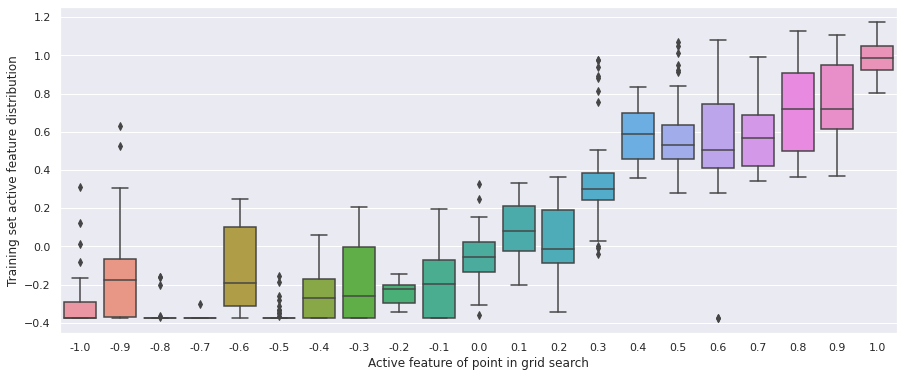

Active feature ind = 10, name = amount_remaining


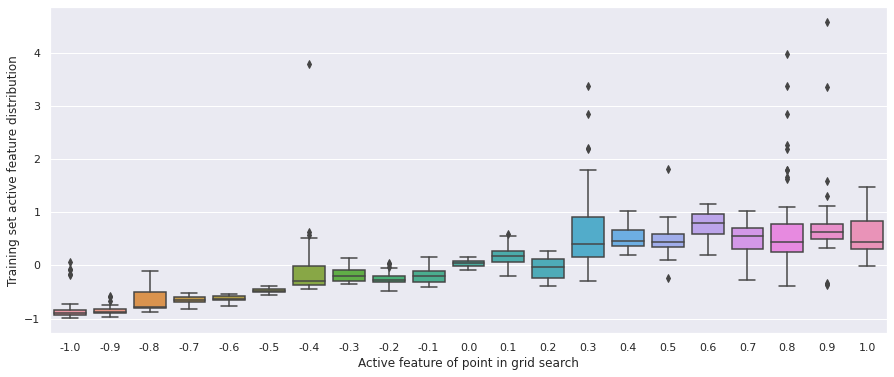

Active feature ind = 6, name = num_donors


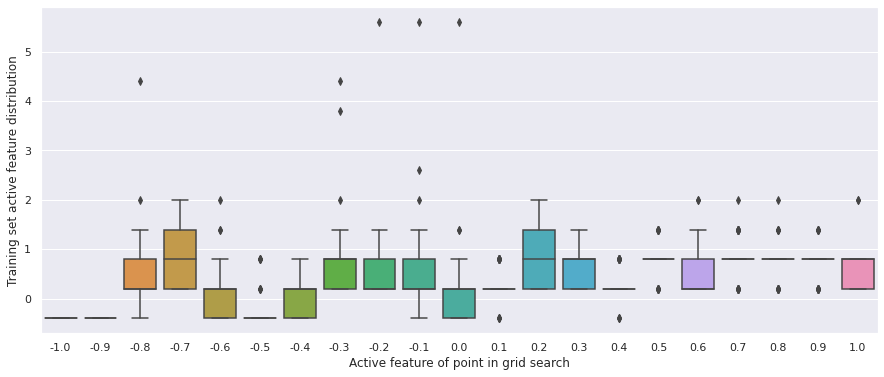

Active feature ind = 8, name = avg_msg_num_words


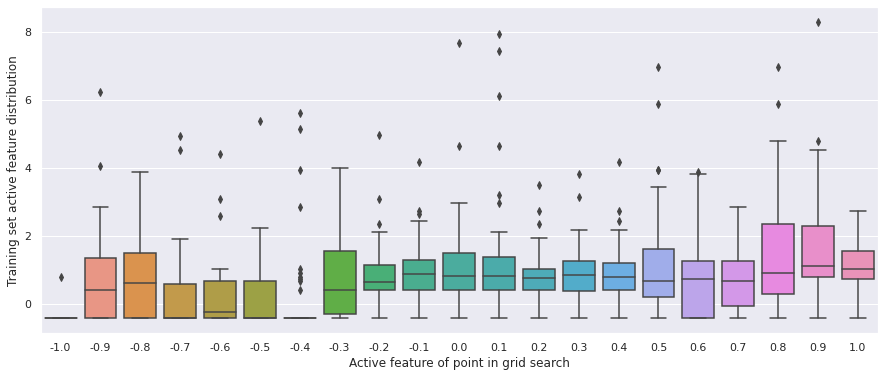

Active feature ind = 0, name = total_price_excluding_optional_support


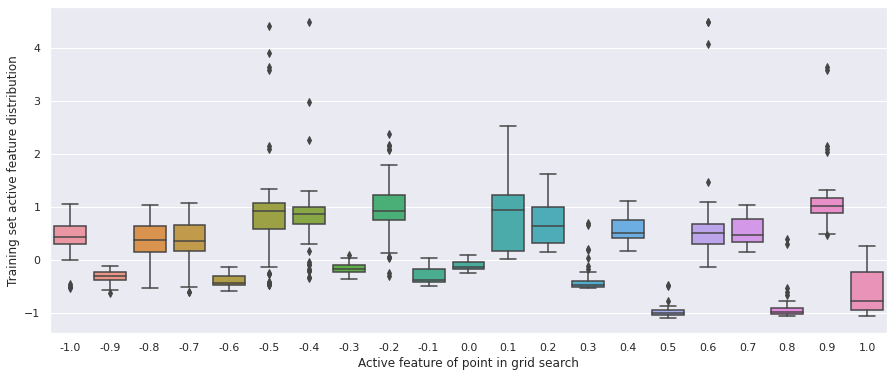

Active feature ind = 7, name = num_teachers


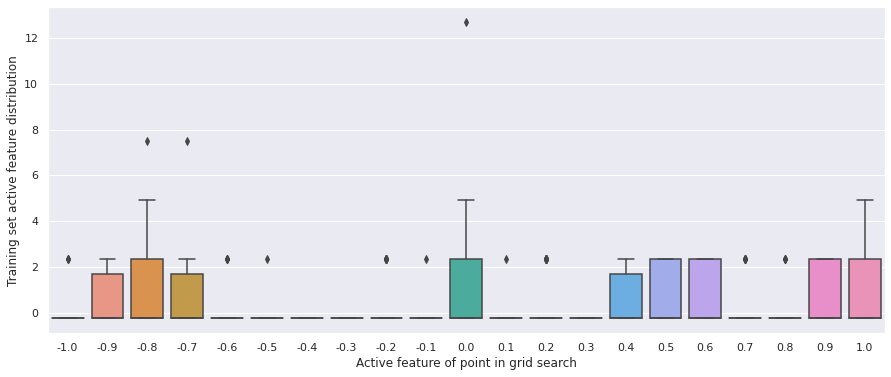

Active feature ind = 20, name = poverty_level


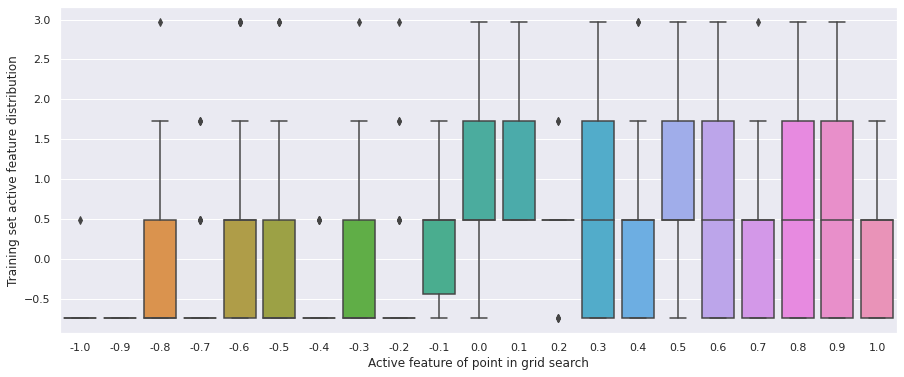

Active feature ind = 19, name = resource_type


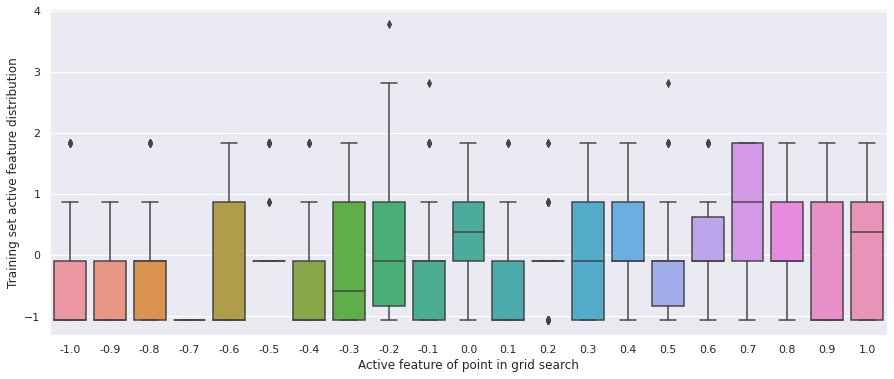

Active feature ind = 18, name = primary_focus_subject


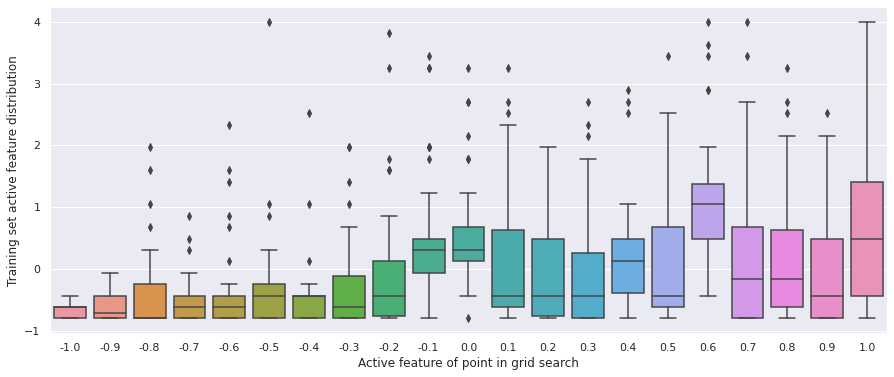

Active feature ind = 17, name = teacher_teach_for_america


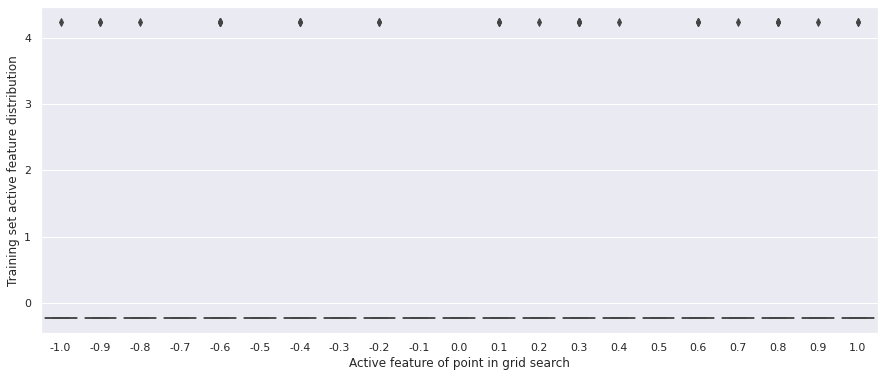

In [ ]:
datasets = ["donors_choose"]
trials = []
for i in range(3):
    trials.append(i + 1)

dataset = datasets[0]
trial = trials[0]
m_name = dataset + "_" + str(trial) + ".txt"

population = 50
with open(m_name,'rb') as f:
    exp_maple = pickle.load(f)
    print('maple model loaded from ', m_name, ' with best retain = ', exp_maple.retain)


for feature_ind in mostImpFeats[:exp_maple.retain]:
    
    print('Active feature ind = {}, name = {}'.format(feature_ind, features.columns[feature_ind]))
    title = features.columns[feature_ind][0]
    data = np.zeros((population, 23))
    grid = np.linspace(-1.0, 1.0, 21)
    new_flag = 1
    for g in grid:
      # sampled_test = np.random.uniform(low=0.0, high=1.0, size = 11)
      sampled_test = np.random.normal(loc = 0.0, scale = 1.0, size = 23)
      sampled_test[feature_ind] = g
      sampled_test = np.reshape(sampled_test, (1,-1))
      # e_maple = exp_maple.explain(sampled_test)
      
      curr_leaf_ids = exp_maple.fe.apply(sampled_test)[0]
      weights = exp_maple.training_point_weights(curr_leaf_ids)
      local_train_ind = np.argsort(-weights)[:population]
      local_train = X_train[local_train_ind,:]
      if new_flag:
        x = np.ones((population,1)) * g
        x = np.around(x, decimals=1)
        y = local_train[:,feature_ind].reshape(-1,1)
      else:
        tmp = np.ones((population,1)) * g
        tmp = np.around(tmp, decimals=1)
        x = np.vstack((x, tmp))
        y = np.vstack((y, local_train[:,feature_ind].reshape(-1,1)))
      
      # print('local_train.shape={}, grid = {:.2f}, x.shape = {}, y.shape = {}'.format(local_train.shape, g, x.shape, y.shape))

      new_flag = 0
    x = x.flatten()
    y = y.flatten()

    df = pd.DataFrame({"x":x, "y":y})
    # print(df)
    sns.boxplot(x='x', y='y', data=df)
    sns.set(rc={'figure.figsize':(15,6)})
    # plt.title('Active Feature: ', title)
    plt.xlabel('Active feature of point in grid search')
    plt.ylabel('Training set active feature distribution')
    plt.show()

      




maple model loaded from  donors_choose_2.txt  with best retain =  10
Active feature ind = 9, name = percent_fulfilled


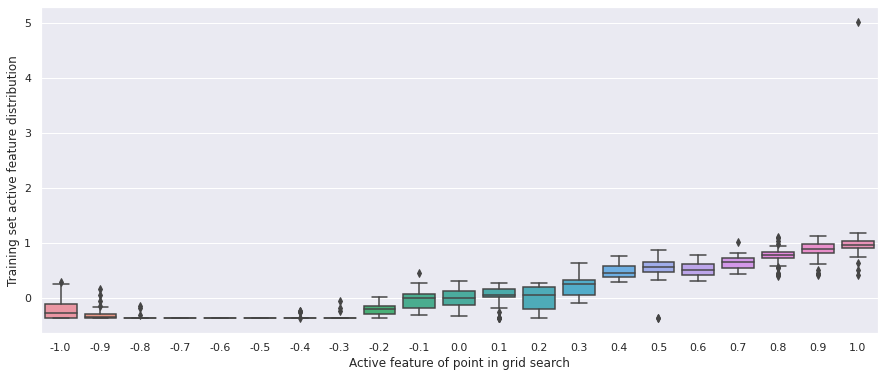

Active feature ind = 10, name = amount_remaining


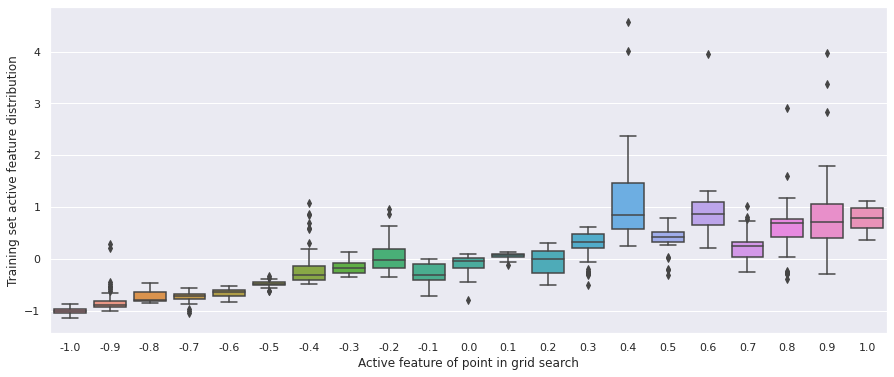

Active feature ind = 6, name = num_donors


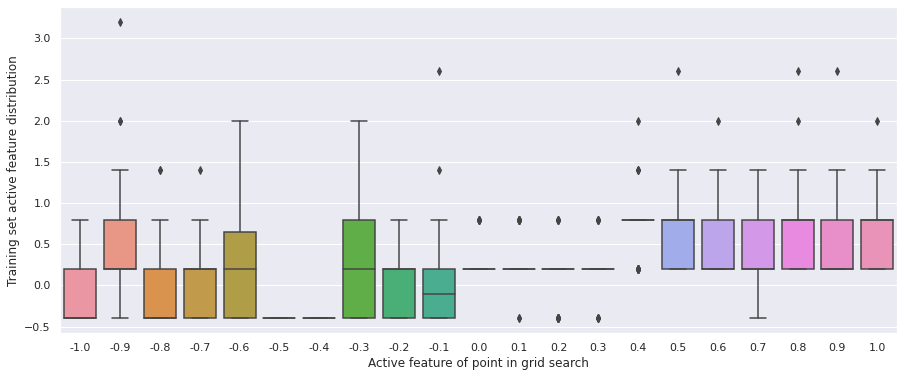

Active feature ind = 8, name = avg_msg_num_words


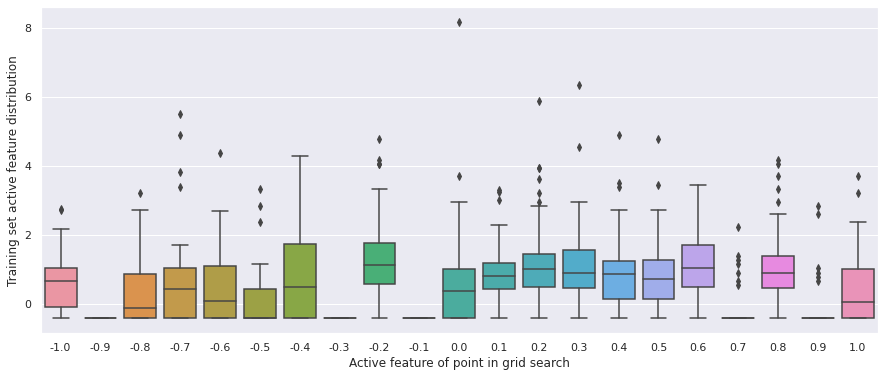

Active feature ind = 0, name = total_price_excluding_optional_support


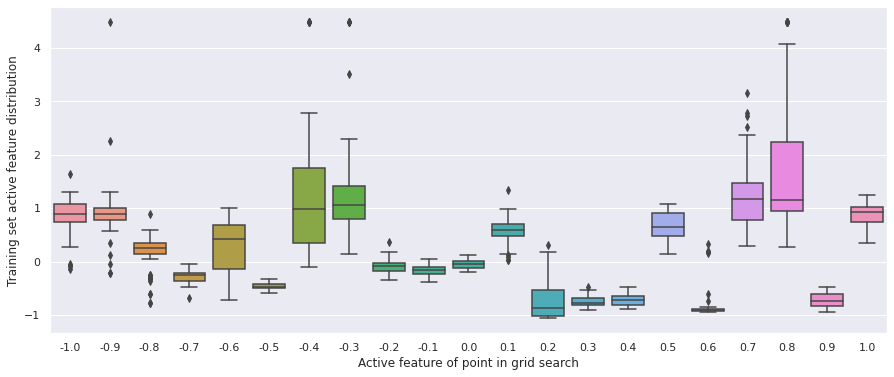

Active feature ind = 7, name = num_teachers


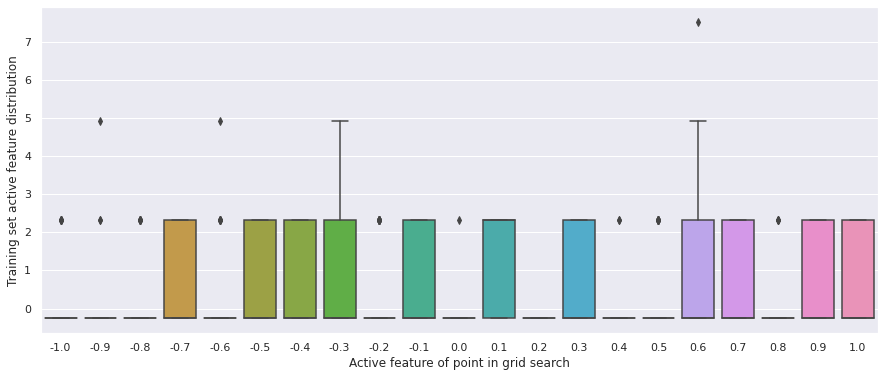

Active feature ind = 20, name = poverty_level


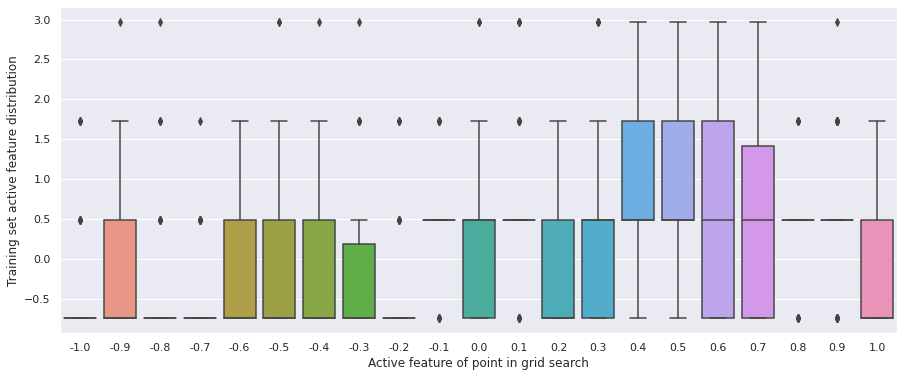

Active feature ind = 19, name = resource_type


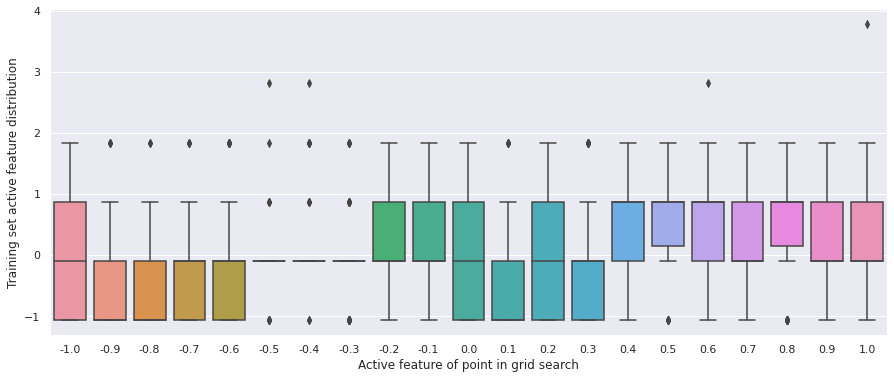

Active feature ind = 18, name = primary_focus_subject


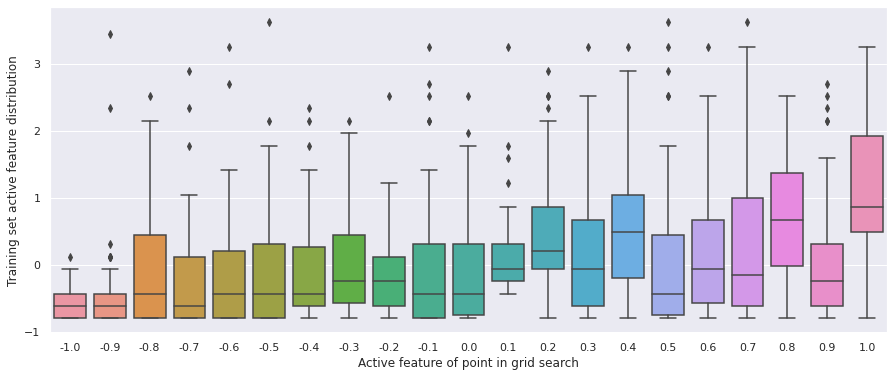

Active feature ind = 17, name = teacher_teach_for_america


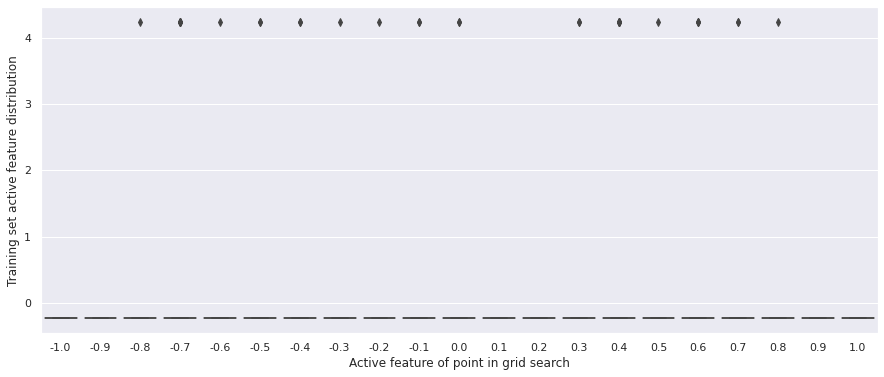

In [ ]:
datasets = ["donors_choose"]
trials = []
for i in range(3):
    trials.append(i + 1)

dataset = datasets[0]
trial = trials[1]
m_name = dataset + "_" + str(trial) + ".txt"

population = 50
with open(m_name,'rb') as f:
    exp_maple = pickle.load(f)
    print('maple model loaded from ', m_name, ' with best retain = ', exp_maple.retain)


for feature_ind in mostImpFeats[:exp_maple.retain]:
    
    print('Active feature ind = {}, name = {}'.format(feature_ind, features.columns[feature_ind]))
    title = features.columns[feature_ind][0]
    data = np.zeros((population, 23))
    grid = np.linspace(-1.0, 1.0, 21)
    new_flag = 1
    for g in grid:
      # sampled_test = np.random.uniform(low=0.0, high=1.0, size = 11)
      sampled_test = np.random.normal(loc = 0.0, scale = 1.0, size = 23)
      sampled_test[feature_ind] = g
      sampled_test = np.reshape(sampled_test, (1,-1))
      # e_maple = exp_maple.explain(sampled_test)
      
      curr_leaf_ids = exp_maple.fe.apply(sampled_test)[0]
      weights = exp_maple.training_point_weights(curr_leaf_ids)
      local_train_ind = np.argsort(-weights)[:population]
      local_train = X_train[local_train_ind,:]
      if new_flag:
        x = np.ones((population,1)) * g
        x = np.around(x, decimals=1)
        y = local_train[:,feature_ind].reshape(-1,1)
      else:
        tmp = np.ones((population,1)) * g
        tmp = np.around(tmp, decimals=1)
        x = np.vstack((x, tmp))
        y = np.vstack((y, local_train[:,feature_ind].reshape(-1,1)))
      
      # print('local_train.shape={}, grid = {:.2f}, x.shape = {}, y.shape = {}'.format(local_train.shape, g, x.shape, y.shape))

      new_flag = 0
    x = x.flatten()
    y = y.flatten()

    df = pd.DataFrame({"x":x, "y":y})
    # print(df)
    sns.boxplot(x='x', y='y', data=df)
    sns.set(rc={'figure.figsize':(15,6)})
    # plt.title('Active Feature: ', title)
    plt.xlabel('Active feature of point in grid search')
    plt.ylabel('Training set active feature distribution')
    plt.show()

      




maple model loaded from  donors_choose_3.txt  with best retain =  16
Active feature ind = 9, name = percent_fulfilled


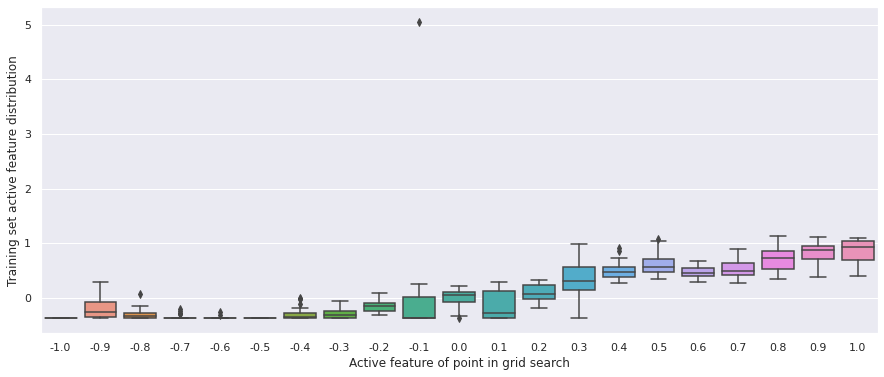

Active feature ind = 10, name = amount_remaining


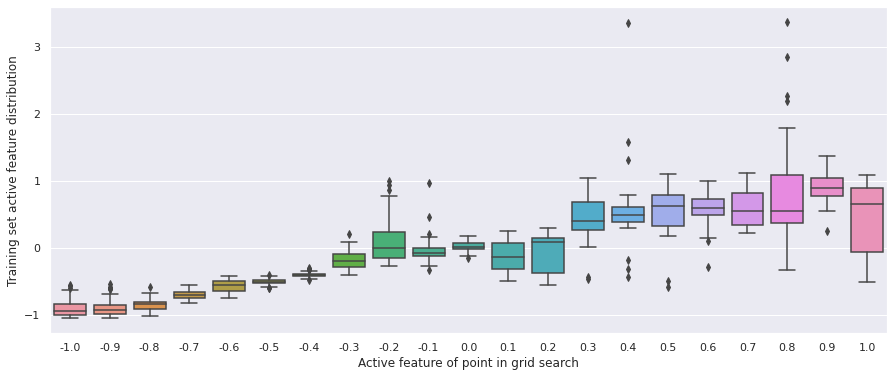

Active feature ind = 6, name = num_donors


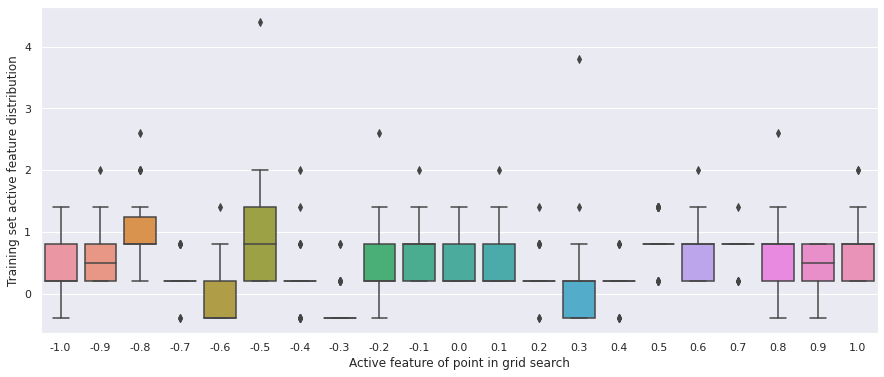

Active feature ind = 8, name = avg_msg_num_words


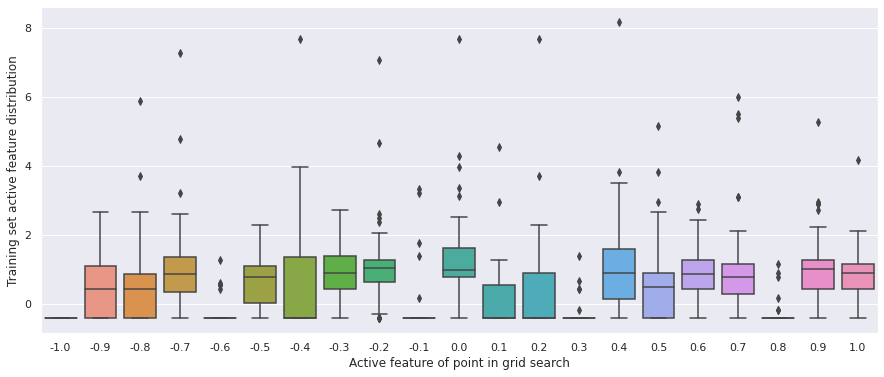

Active feature ind = 0, name = total_price_excluding_optional_support


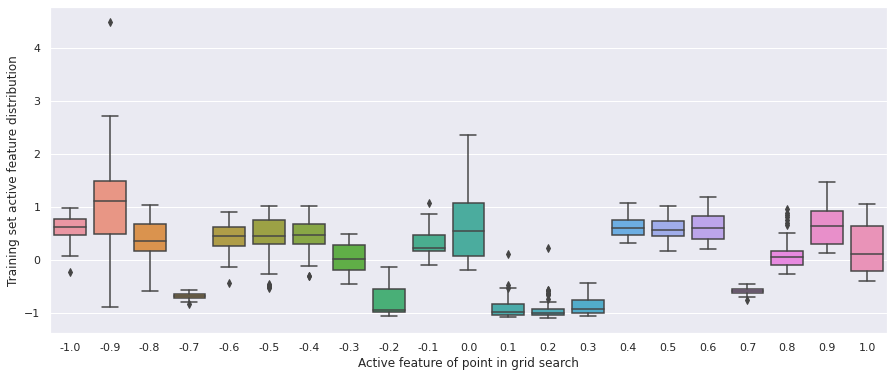

Active feature ind = 7, name = num_teachers


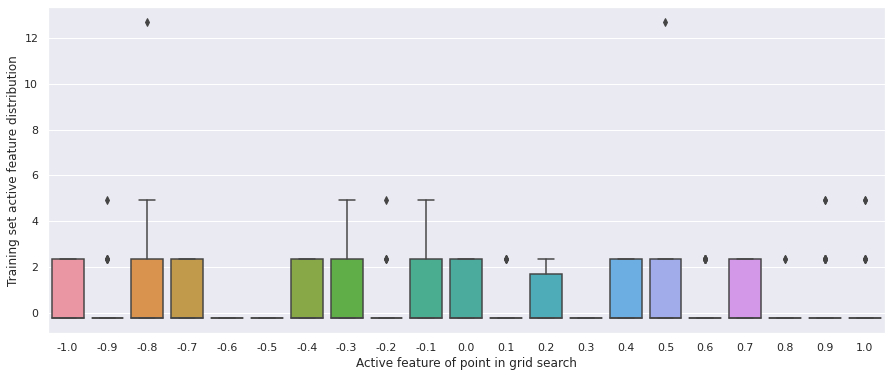

Active feature ind = 20, name = poverty_level


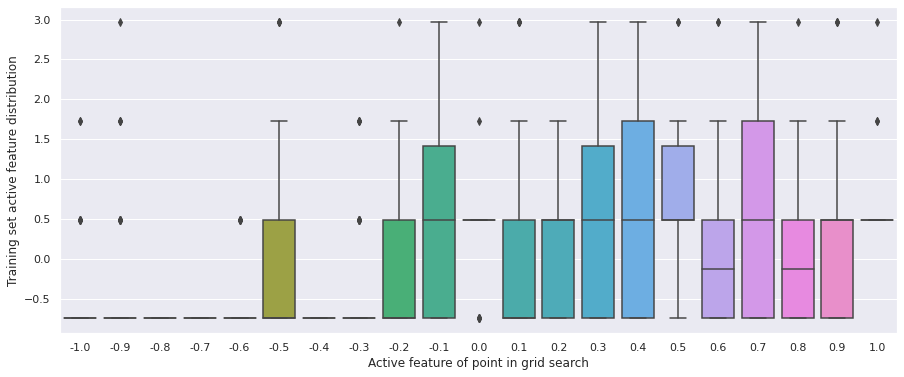

Active feature ind = 19, name = resource_type


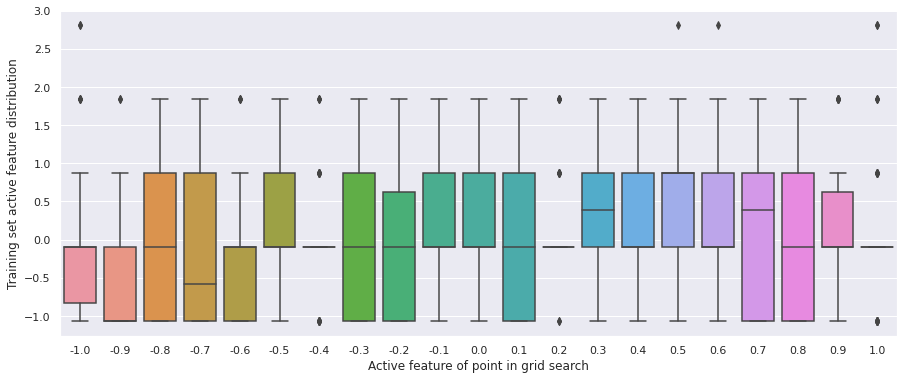

Active feature ind = 18, name = primary_focus_subject


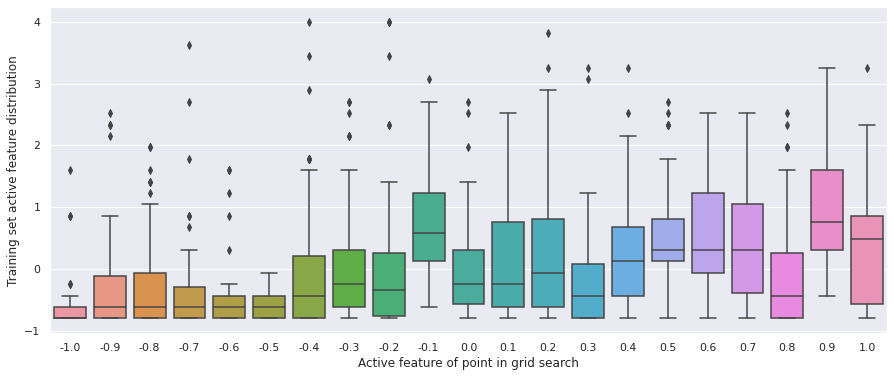

Active feature ind = 17, name = teacher_teach_for_america


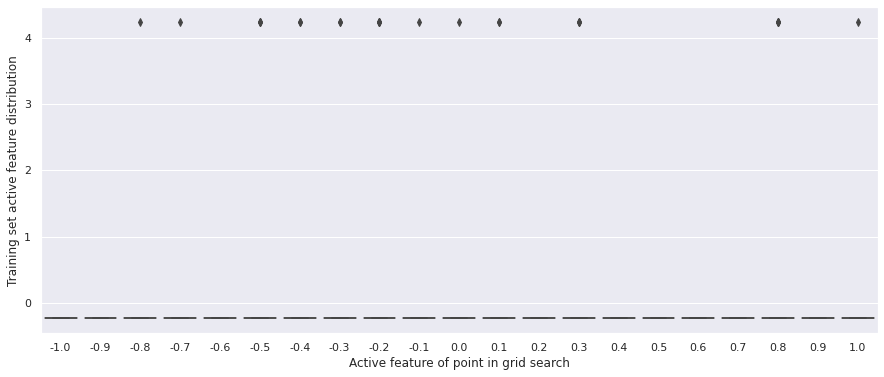

Active feature ind = 16, name = teacher_prefix


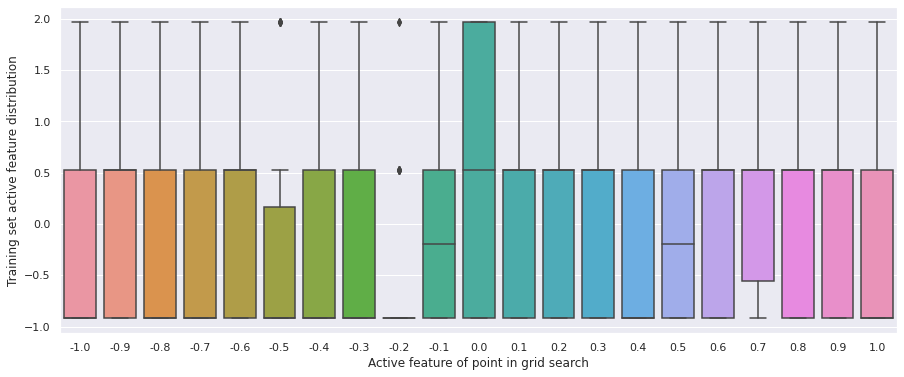

Active feature ind = 15, name = school_charter


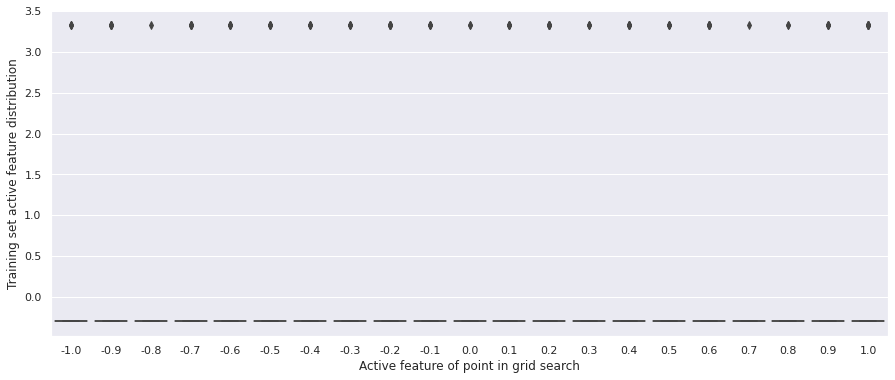

Active feature ind = 14, name = school_metro


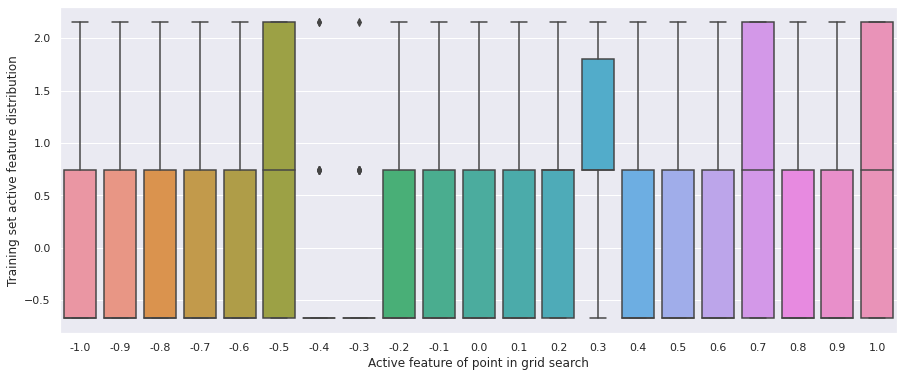

Active feature ind = 11, name = school_pct_funded


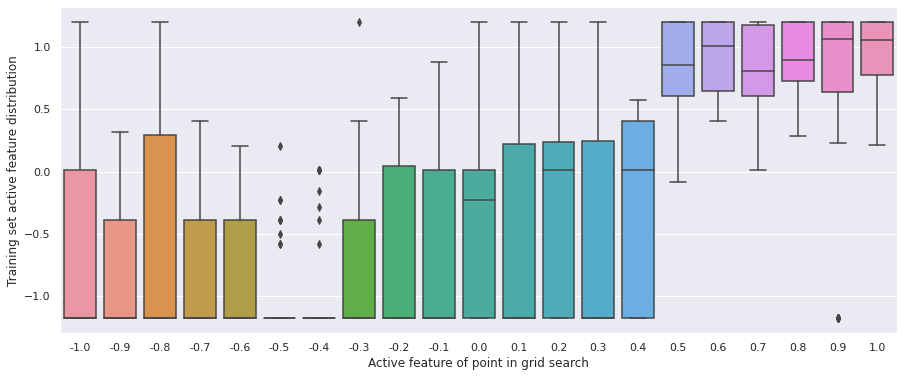

Active feature ind = 12, name = teacher_pct_funded


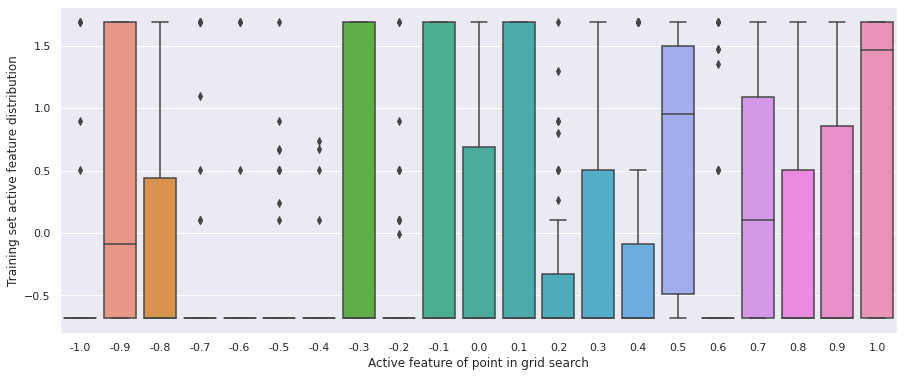

Active feature ind = 21, name = grade_level


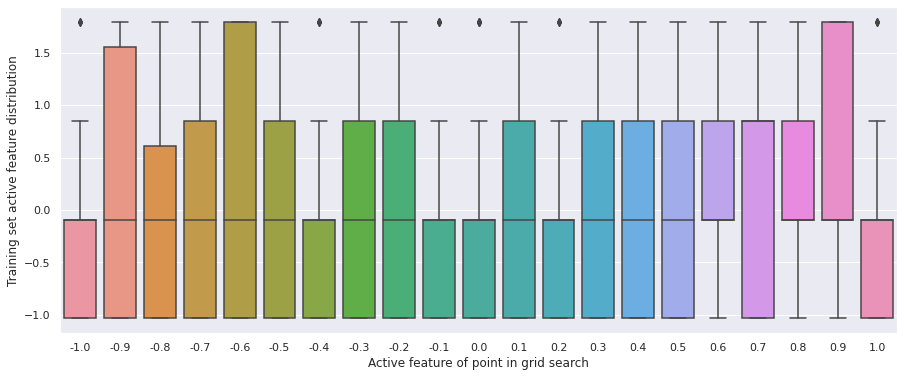

In [ ]:
datasets = ["donors_choose"]
trials = []
for i in range(3):
    trials.append(i + 1)

dataset = datasets[0]
trial = trials[2]
m_name = dataset + "_" + str(trial) + ".txt"

population = 50
with open(m_name,'rb') as f:
    exp_maple = pickle.load(f)
    print('maple model loaded from ', m_name, ' with best retain = ', exp_maple.retain)


for feature_ind in mostImpFeats[:exp_maple.retain]:
    
    print('Active feature ind = {}, name = {}'.format(feature_ind, features.columns[feature_ind]))
    title = features.columns[feature_ind][0]
    data = np.zeros((population, 23))
    grid = np.linspace(-1.0, 1.0, 21)
    new_flag = 1
    for g in grid:
      # sampled_test = np.random.uniform(low=0.0, high=1.0, size = 11)
      sampled_test = np.random.normal(loc = 0.0, scale = 1.0, size = 23)
      sampled_test[feature_ind] = g
      sampled_test = np.reshape(sampled_test, (1,-1))
      # e_maple = exp_maple.explain(sampled_test)
      
      curr_leaf_ids = exp_maple.fe.apply(sampled_test)[0]
      weights = exp_maple.training_point_weights(curr_leaf_ids)
      local_train_ind = np.argsort(-weights)[:population]
      local_train = X_train[local_train_ind,:]
      if new_flag:
        x = np.ones((population,1)) * g
        x = np.around(x, decimals=1)
        y = local_train[:,feature_ind].reshape(-1,1)
      else:
        tmp = np.ones((population,1)) * g
        tmp = np.around(tmp, decimals=1)
        x = np.vstack((x, tmp))
        y = np.vstack((y, local_train[:,feature_ind].reshape(-1,1)))
      
      # print('local_train.shape={}, grid = {:.2f}, x.shape = {}, y.shape = {}'.format(local_train.shape, g, x.shape, y.shape))

      new_flag = 0
    x = x.flatten()
    y = y.flatten()

    df = pd.DataFrame({"x":x, "y":y})
    # print(df)
    sns.boxplot(x='x', y='y', data=df)
    sns.set(rc={'figure.figsize':(15,6)})
    # plt.title('Active Feature: ', title)
    plt.xlabel('Active feature of point in grid search')
    plt.ylabel('Training set active feature distribution')
    plt.show()

      




**apply maple model, obtain pr-k graph and performance**

In [ ]:
n = X_test.shape[0]
d = X_test.shape[1]

In [ ]:
def maplePRK(modelNum):
  m_name = "donors_choose" + "_" + str(modelNum) + ".txt"
  print('Load Maple for ', m_name)
  with open(m_name,'rb') as f:
      exp_maple = pickle.load(f)

  maple_prob = np.zeros(n)
  for i in range(n):
    
      if i % 500 == 0:
          print('@ i = ', i)
      x = X_test[i, :]
      
      e_maple = exp_maple.explain(x)
      coefs_maple = e_maple["coefs"]
      

      maple_pred = np.dot(np.insert(x, 0, 1), coefs_maple)
      maple_prob[i] = maple_pred
  
  y_test_pred =  maple_prob
  Y_test = y_test
  y_score = pd.Series(y_test_pred)
  Y_test_np = Y_test
  Y_test_pd = pd.Series(Y_test_np)
  combo = pd.concat([Y_test_pd, y_score], axis=1)
  combo.columns = ['fully_funded', 'pred']

  grid = np.arange(0,1.02,0.02)
  pre_log, rec_log = np.zeros_like(grid), np.zeros_like(grid)
  for i, k in enumerate(grid):
    pre_log[i], rec_log[i] = prk(combo, k)
    if k == 0.1:
      print('precision @ k = {}'.format(pre_log[i]))

  # f, axs = plt.subplots(1,2,figsize=(15,5))
  # axs1 = axs[0]
  f, axs1 = plt.subplots()
  plt.title('Maple model' + str(modelNum))
  axs2 = axs1.twinx()
  axs1.plot(grid, pre_log, 'b', label = 'Precision')
  axs2.plot(grid, rec_log, 'r', label = 'Recall')
  axs1.set_ylabel('Precision', color = 'b')
  axs1.set_ylim(-0.05,1.05)
  axs2.set_ylabel('Recall', color = 'r')
  axs2.set_ylim(-0.05,1.05)
  axs1.set_xlabel('k: Percent of projects identified as 1: not fully funded')
  plt.show()
  
  

Load Maple for  donors_choose_1.txt
@ i =  0
@ i =  500
@ i =  1000
@ i =  1500
@ i =  2000
@ i =  2500
@ i =  3000
@ i =  3500
@ i =  4000
@ i =  4500
@ i =  5000
@ i =  5500
@ i =  6000
@ i =  6500
precision @ k = 0.8197424892703863


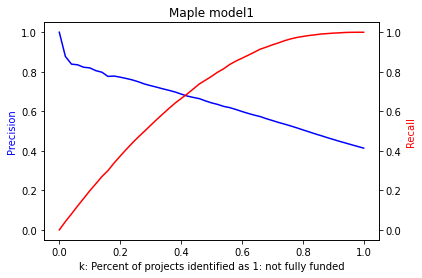

In [ ]:
maplePRK(1)

Load Maple for  donors_choose_2.txt
@ i =  0
@ i =  500
@ i =  1000
@ i =  1500
@ i =  2000
@ i =  2500
@ i =  3000
@ i =  3500
@ i =  4000
@ i =  4500
@ i =  5000
@ i =  5500
@ i =  6000
@ i =  6500
precision @ k = 0.8154506437768241


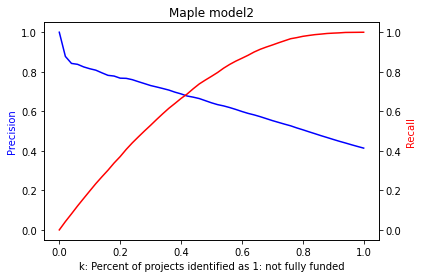

In [ ]:
maplePRK(2)

Load Maple for  donors_choose_3.txt
@ i =  0
@ i =  500
@ i =  1000
@ i =  1500
@ i =  2000
@ i =  2500
@ i =  3000
@ i =  3500
@ i =  4000
@ i =  4500
@ i =  5000
@ i =  5500
@ i =  6000
@ i =  6500
precision @ k = 0.8226037195994278


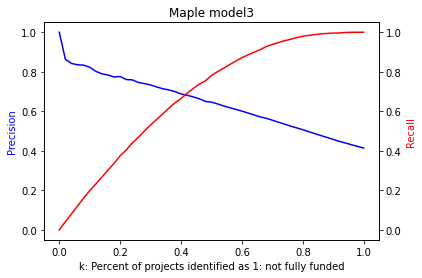

In [ ]:
maplePRK(3)

**Add SLIM pr-k**

In [84]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"

# Base imports
import itertools
import json
import math
from multiprocessing import Pool
import numpy as np
import pandas as pd
import scipy
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier

# Code imports
import sys

from Misc import load_normalize_data, unpack_coefs

from lime import lime_tabular
import pickle


global exp_lime
exp_lime = lime_tabular.LimeTabularExplainer(X_train, discretize_continuous=False, mode="regression")

def slimPRK():
  print('fitting rf')
  model = RandomForestClassifier(n_estimators = 500, min_samples_split = 25, random_state=0)
  model.fit(X_train, y_train)
  def rf_to_regression(x, m = model.predict_proba):
    return m(x)[:,1]

  

  slim_prob = np.zeros(n)
  for i in range(n):
    
      if i % 100 == 0:
          print('@ i = ', i)
      x = X_test[i, :]

      coefs_lime = unpack_coefs(exp_lime, x, rf_to_regression, d, X_train) #Allow full number of features
      lime_pred = np.dot(np.insert(x, 0, 1), coefs_lime)

      slim_prob[i] = lime_pred
  return slim_prob
  
  
  
  

In [85]:
slim_prob = slimPRK()

fitting rf
@ i =  0
@ i =  100
@ i =  200
@ i =  300
@ i =  400
@ i =  500
@ i =  600
@ i =  700
@ i =  800
@ i =  900
@ i =  1000
@ i =  1100
@ i =  1200
@ i =  1300
@ i =  1400
@ i =  1500
@ i =  1600
@ i =  1700
@ i =  1800
@ i =  1900
@ i =  2000
@ i =  2100
@ i =  2200
@ i =  2300
@ i =  2400
@ i =  2500
@ i =  2600
@ i =  2700
@ i =  2800
@ i =  2900
@ i =  3000
@ i =  3100
@ i =  3200
@ i =  3300
@ i =  3400
@ i =  3500
@ i =  3600
@ i =  3700
@ i =  3800
@ i =  3900
@ i =  4000
@ i =  4100
@ i =  4200
@ i =  4300
@ i =  4400
@ i =  4500
@ i =  4600
@ i =  4700
@ i =  4800
@ i =  4900
@ i =  5000
@ i =  5100
@ i =  5200
@ i =  5300
@ i =  5400
@ i =  5500
@ i =  5600
@ i =  5700
@ i =  5800
@ i =  5900
@ i =  6000
@ i =  6100
@ i =  6200
@ i =  6300
@ i =  6400
@ i =  6500
@ i =  6600
@ i =  6700
@ i =  6800
@ i =  6900


precision @ k = 0.8111587982832618


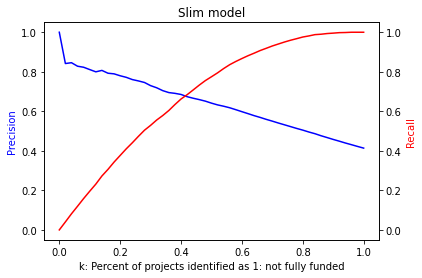

In [86]:
y_test_pred = slim_prob
Y_test = y_test
y_score = pd.Series(y_test_pred)
Y_test_np = Y_test
Y_test_pd = pd.Series(Y_test_np)
combo = pd.concat([Y_test_pd, y_score], axis=1)
combo.columns = ['fully_funded', 'pred']

grid = np.arange(0,1.02,0.02)
pre_log, rec_log = np.zeros_like(grid), np.zeros_like(grid)
for i, k in enumerate(grid):
  pre_log[i], rec_log[i] = prk(combo, k)
  if k == 0.1:
    print('precision @ k = {}'.format(pre_log[i]))

# f, axs = plt.subplots(1,2,figsize=(15,5))
# axs1 = axs[0]
f, axs1 = plt.subplots()
plt.title('Slim model')
axs2 = axs1.twinx()
axs1.plot(grid, pre_log, 'b', label = 'Precision')
axs2.plot(grid, rec_log, 'r', label = 'Recall')
axs1.set_ylabel('Precision', color = 'b')
axs1.set_ylim(-0.05,1.05)
axs2.set_ylabel('Recall', color = 'r')
axs2.set_ylim(-0.05,1.05)
axs1.set_xlabel('k: Percent of projects identified as 1: not fully funded')
plt.show()